In [1]:

import h5py
import time
import numpy as np
import pandas as pd
from pathlib import Path
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
def show_scatter(data: np.ndarray, color: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('white')
    ff = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color)
    plt.colorbar(ff)
    plt.show()

In [17]:
results_dir = Path("anca_ae_results")
results_dir.mkdir(exist_ok=True)

In [12]:
data_files = list(Path("data").glob("**/*.npy"))

In [14]:
len(data_files)

1107

In [16]:
positions = [np.load(p) for p in data_files]

In [18]:
positions = np.concatenate(positions)

In [19]:
positions.shape

(866708, 3, 665)

In [20]:
from mdlearn.data.preprocess.align import iterative_means_align

In [21]:
itr, avg_coords, e_rmsd, coords = iterative_means_align(
    positions, eps=0.001, max_iter=10, num_workers=75, verbose=True
)

Shape of coords array in iterative_means: (866708, 3, 665)
Iteration #1 with an error of 5.4459624439403855
Iteration #2 with an error of 0.0010506558835777014
Iteration #3 with an error of 2.984254692027876e-06


In [22]:
np.save(results_dir / "coords.npy", coords)
np.save(results_dir / "e_rmsd.npy", e_rmsd)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

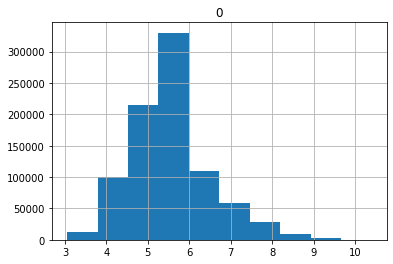

In [23]:
pd.DataFrame(e_rmsd[-1]).hist()

In [24]:
subset_coords = coords[::10, :, :]

In [25]:
subset_coords.shape

(86671, 3, 665)

In [26]:
from mdlearn.data.preprocess.decorrelation.spatial import SD2

In [27]:
Y, S, B, U = SD2(subset_coords.reshape(-1, 665*3), m=665*3, verbose=True)

2nd order Spatial Decorrelation -> Looking for 1995 sources
2nd order Spatial Decorrelation -> Removing the mean value
2nd order Spatial Decorrelation -> Whitening the data


/lambda_stor/homes/abrace/src/mdlearn/mdlearn/data/preprocess/decorrelation/spatial.py:99: RuntimeWarning: invalid value encountered in sqrt
  scales = np.sqrt(S)


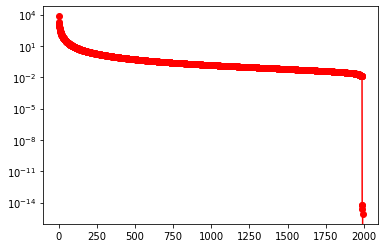

In [28]:

plt.semilogy(S, 'ro-')

In [29]:
from mdlearn.data.preprocess.decorrelation.spatial import SD4

In [32]:

# Use the first 60 principal components
W = SD4(Y[0:40,:], m=40, U=U[0:40,:], verbose=True)

4th order Spatial Decorrelation -> Estimating cumulant matrices
SD4 -> Contrast optimization by joint diagonalization
SD4 -> Sweep #0
completed in 780 rotations
SD4 -> Sweep #1
completed in 780 rotations
SD4 -> Sweep #2
completed in 780 rotations
SD4 -> Sweep #3
completed in 780 rotations
SD4 -> Sweep #4
completed in 780 rotations
SD4 -> Sweep #5
completed in 780 rotations
SD4 -> Sweep #6
completed in 780 rotations
SD4 -> Sweep #7
completed in 780 rotations
SD4 -> Sweep #8
completed in 780 rotations
SD4 -> Sweep #9
completed in 780 rotations
SD4 -> Sweep #10
completed in 780 rotations
SD4 -> Sweep #11
completed in 780 rotations
SD4 -> Sweep #12
completed in 780 rotations
SD4 -> Sweep #13
completed in 780 rotations
SD4 -> Sweep #14
completed in 780 rotations
SD4 -> Sweep #15
completed in 780 rotations
SD4 -> Sweep #16
completed in 780 rotations
SD4 -> Sweep #17
completed in 780 rotations
SD4 -> Sweep #18
completed in 780 rotations
SD4 -> Sweep #19
completed in 780 rotations
SD4 -> Sweep

completed in 393 rotations
SD4 -> Sweep #183
completed in 400 rotations
SD4 -> Sweep #184
completed in 378 rotations
SD4 -> Sweep #185
completed in 376 rotations
SD4 -> Sweep #186
completed in 359 rotations
SD4 -> Sweep #187
completed in 345 rotations
SD4 -> Sweep #188
completed in 336 rotations
SD4 -> Sweep #189
completed in 345 rotations
SD4 -> Sweep #190
completed in 318 rotations
SD4 -> Sweep #191
completed in 338 rotations
SD4 -> Sweep #192
completed in 282 rotations
SD4 -> Sweep #193
completed in 305 rotations
SD4 -> Sweep #194
completed in 284 rotations
SD4 -> Sweep #195
completed in 283 rotations
SD4 -> Sweep #196
completed in 254 rotations
SD4 -> Sweep #197
completed in 273 rotations
SD4 -> Sweep #198
completed in 248 rotations
SD4 -> Sweep #199
completed in 239 rotations
SD4 -> Sweep #200
completed in 245 rotations
SD4 -> Sweep #201
completed in 246 rotations
SD4 -> Sweep #202
completed in 211 rotations
SD4 -> Sweep #203
completed in 189 rotations
SD4 -> Sweep #204
completed 

In [34]:
np.save(results_dir / "W.npy", W)

In [35]:
W.shape

(40, 1995)

In [36]:
coordsAll = np.reshape(coords, (len(coords), coords.shape[1] * coords.shape[2])).T
avgCoordsAll = np.mean(coordsAll, 1)
tmpAll = np.reshape(np.tile(avgCoordsAll, coords.shape[0]), (coords.shape[0], coords.shape[1] * coords.shape[2])).T 
caDevsMDall = coordsAll - tmpAll
caDevsMDall.shape

(1995, 866708)

In [37]:
ZPrj4 = W.dot(caDevsMDall)
ZPrj4.shape

(40, 866708)

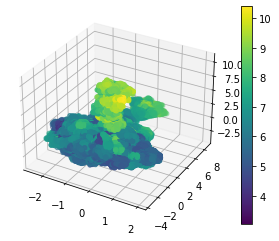

In [39]:
show_scatter(ZPrj4.T[:, :3], e_rmsd[-1])

In [40]:
from mdlearn.nn.models.ae.linear import LinearAETrainer

In [78]:
trainer = LinearAETrainer(
    input_dim=40,
    latent_dim=16,
    hidden_neurons=[32, 24],
    epochs=500,
    verbose=True,
    checkpoint_log_every=10,
    plot_log_every=100,
    plot_n_samples=8000,
    plot_method="raw",
    device="cpu",
)

In [79]:
vars(trainer)

{'seed': 42,
 'scalar_dset_names': [],
 'in_gpu_memory': False,
 'num_data_workers': 0,
 'persistent_workers': False,
 'prefetch_factor': 2,
 'split_pct': 0.8,
 'split_method': 'random',
 'batch_size': 128,
 'shuffle': True,
 'device': device(type='cpu'),
 'epochs': 500,
 'verbose': True,
 'clip_grad_max_norm': 10.0,
 'checkpoint_log_every': 10,
 'plot_log_every': 100,
 'plot_n_samples': 8000,
 'plot_method': 'raw',
 'train_subsample_pct': 1.0,
 'valid_subsample_pct': 1.0,
 'use_wandb': False,
 'optimizer_name': 'RMSprop',
 'optimizer_hparams': {'lr': 0.001, 'weight_decay': 1e-05},
 'scheduler_name': None,
 'scheduler_hparams': {},
 'model': LinearAE(
   (encoder): DenseNet(
     (model): Sequential(
       (0): Linear(in_features=40, out_features=32, bias=True)
       (1): ReLU()
       (2): Linear(in_features=32, out_features=24, bias=True)
       (3): ReLU()
       (4): Linear(in_features=24, out_features=16, bias=True)
     )
   )
   (decoder): DenseNet(
     (model): Sequential(
 

In [80]:
X = ZPrj4.T
X.shape

(866708, 40)

In [81]:
np.save(results_dir / "X.npy", X)

In [82]:
X_subset = X[::10]
scalars = {"rmsd": e_rmsd[-1][::10]}

In [83]:
X_subset.shape

(86671, 40)

In [74]:
import os
os.environ["CUDA_VISBLE_DEVICES"] = "6"

In [84]:
trainer.fit(X_subset, scalars, results_dir / "autoencoder")

====> Epoch: 1 Train:	Avg loss: 0.8088
====> Epoch: 1 Valid:	Avg loss: 0.7362

====> Epoch: 2 Train:	Avg loss: 0.6882
====> Epoch: 2 Valid:	Avg loss: 0.6587

====> Epoch: 3 Train:	Avg loss: 0.6283
====> Epoch: 3 Valid:	Avg loss: 0.6056

====> Epoch: 4 Train:	Avg loss: 0.5811
====> Epoch: 4 Valid:	Avg loss: 0.5565

====> Epoch: 5 Train:	Avg loss: 0.5467
====> Epoch: 5 Valid:	Avg loss: 0.5329

====> Epoch: 6 Train:	Avg loss: 0.5279
====> Epoch: 6 Valid:	Avg loss: 0.5222

====> Epoch: 7 Train:	Avg loss: 0.5150
====> Epoch: 7 Valid:	Avg loss: 0.5100

====> Epoch: 8 Train:	Avg loss: 0.5054
====> Epoch: 8 Valid:	Avg loss: 0.4997

====> Epoch: 9 Train:	Avg loss: 0.4979
====> Epoch: 9 Valid:	Avg loss: 0.4916

====> Epoch: 10 Train:	Avg loss: 0.4916
====> Epoch: 10 Valid:	Avg loss: 0.4856

====> Epoch: 11 Train:	Avg loss: 0.4857
====> Epoch: 11 Valid:	Avg loss: 0.4804

====> Epoch: 12 Train:	Avg loss: 0.4774
====> Epoch: 12 Valid:	Avg loss: 0.4713

====> Epoch: 13 Train:	Avg loss: 0.4691
====> 

====> Epoch: 102 Valid:	Avg loss: 0.3983

====> Epoch: 103 Train:	Avg loss: 0.3953
====> Epoch: 103 Valid:	Avg loss: 0.3954

====> Epoch: 104 Train:	Avg loss: 0.3951
====> Epoch: 104 Valid:	Avg loss: 0.3952

====> Epoch: 105 Train:	Avg loss: 0.3951
====> Epoch: 105 Valid:	Avg loss: 0.3963

====> Epoch: 106 Train:	Avg loss: 0.3951
====> Epoch: 106 Valid:	Avg loss: 0.3980

====> Epoch: 107 Train:	Avg loss: 0.3949
====> Epoch: 107 Valid:	Avg loss: 0.3929

====> Epoch: 108 Train:	Avg loss: 0.3949
====> Epoch: 108 Valid:	Avg loss: 0.3954

====> Epoch: 109 Train:	Avg loss: 0.3947
====> Epoch: 109 Valid:	Avg loss: 0.4000

====> Epoch: 110 Train:	Avg loss: 0.3948
====> Epoch: 110 Valid:	Avg loss: 0.3939

====> Epoch: 111 Train:	Avg loss: 0.3945
====> Epoch: 111 Valid:	Avg loss: 0.3990

====> Epoch: 112 Train:	Avg loss: 0.3945
====> Epoch: 112 Valid:	Avg loss: 0.3978

====> Epoch: 113 Train:	Avg loss: 0.3944
====> Epoch: 113 Valid:	Avg loss: 0.3948

====> Epoch: 114 Train:	Avg loss: 0.3943
====

====> Epoch: 201 Valid:	Avg loss: 0.4011

====> Epoch: 202 Train:	Avg loss: 0.3888
====> Epoch: 202 Valid:	Avg loss: 0.3901

====> Epoch: 203 Train:	Avg loss: 0.3888
====> Epoch: 203 Valid:	Avg loss: 0.3950

====> Epoch: 204 Train:	Avg loss: 0.3887
====> Epoch: 204 Valid:	Avg loss: 0.3891

====> Epoch: 205 Train:	Avg loss: 0.3888
====> Epoch: 205 Valid:	Avg loss: 0.3910

====> Epoch: 206 Train:	Avg loss: 0.3887
====> Epoch: 206 Valid:	Avg loss: 0.3885

====> Epoch: 207 Train:	Avg loss: 0.3888
====> Epoch: 207 Valid:	Avg loss: 0.3921

====> Epoch: 208 Train:	Avg loss: 0.3886
====> Epoch: 208 Valid:	Avg loss: 0.3933

====> Epoch: 209 Train:	Avg loss: 0.3886
====> Epoch: 209 Valid:	Avg loss: 0.3920

====> Epoch: 210 Train:	Avg loss: 0.3886
====> Epoch: 210 Valid:	Avg loss: 0.3949

====> Epoch: 211 Train:	Avg loss: 0.3886
====> Epoch: 211 Valid:	Avg loss: 0.3887

====> Epoch: 212 Train:	Avg loss: 0.3886
====> Epoch: 212 Valid:	Avg loss: 0.3895

====> Epoch: 213 Train:	Avg loss: 0.3885
====

====> Epoch: 300 Valid:	Avg loss: 0.3909

====> Epoch: 301 Train:	Avg loss: 0.3866
====> Epoch: 301 Valid:	Avg loss: 0.3885

====> Epoch: 302 Train:	Avg loss: 0.3864
====> Epoch: 302 Valid:	Avg loss: 0.3893

====> Epoch: 303 Train:	Avg loss: 0.3864
====> Epoch: 303 Valid:	Avg loss: 0.3938

====> Epoch: 304 Train:	Avg loss: 0.3864
====> Epoch: 304 Valid:	Avg loss: 0.3903

====> Epoch: 305 Train:	Avg loss: 0.3864
====> Epoch: 305 Valid:	Avg loss: 0.3859

====> Epoch: 306 Train:	Avg loss: 0.3864
====> Epoch: 306 Valid:	Avg loss: 0.3930

====> Epoch: 307 Train:	Avg loss: 0.3864
====> Epoch: 307 Valid:	Avg loss: 0.3896

====> Epoch: 308 Train:	Avg loss: 0.3864
====> Epoch: 308 Valid:	Avg loss: 0.3942

====> Epoch: 309 Train:	Avg loss: 0.3862
====> Epoch: 309 Valid:	Avg loss: 0.3900

====> Epoch: 310 Train:	Avg loss: 0.3863
====> Epoch: 310 Valid:	Avg loss: 0.3945

====> Epoch: 311 Train:	Avg loss: 0.3862
====> Epoch: 311 Valid:	Avg loss: 0.3892

====> Epoch: 312 Train:	Avg loss: 0.3864
====

====> Epoch: 399 Valid:	Avg loss: 0.3932

====> Epoch: 400 Train:	Avg loss: 0.3851
====> Epoch: 400 Valid:	Avg loss: 0.3899

====> Epoch: 401 Train:	Avg loss: 0.3850
====> Epoch: 401 Valid:	Avg loss: 0.3883

====> Epoch: 402 Train:	Avg loss: 0.3848
====> Epoch: 402 Valid:	Avg loss: 0.3877

====> Epoch: 403 Train:	Avg loss: 0.3851
====> Epoch: 403 Valid:	Avg loss: 0.3873

====> Epoch: 404 Train:	Avg loss: 0.3849
====> Epoch: 404 Valid:	Avg loss: 0.3879

====> Epoch: 405 Train:	Avg loss: 0.3850
====> Epoch: 405 Valid:	Avg loss: 0.3892

====> Epoch: 406 Train:	Avg loss: 0.3850
====> Epoch: 406 Valid:	Avg loss: 0.3894

====> Epoch: 407 Train:	Avg loss: 0.3850
====> Epoch: 407 Valid:	Avg loss: 0.3913

====> Epoch: 408 Train:	Avg loss: 0.3848
====> Epoch: 408 Valid:	Avg loss: 0.3911

====> Epoch: 409 Train:	Avg loss: 0.3849
====> Epoch: 409 Valid:	Avg loss: 0.3879

====> Epoch: 410 Train:	Avg loss: 0.3848
====> Epoch: 410 Valid:	Avg loss: 0.3944

====> Epoch: 411 Train:	Avg loss: 0.3848
====

====> Epoch: 498 Valid:	Avg loss: 0.3883

====> Epoch: 499 Train:	Avg loss: 0.3838
====> Epoch: 499 Valid:	Avg loss: 0.3880

====> Epoch: 500 Train:	Avg loss: 0.3837
====> Epoch: 500 Valid:	Avg loss: 0.3874



<AxesSubplot:>

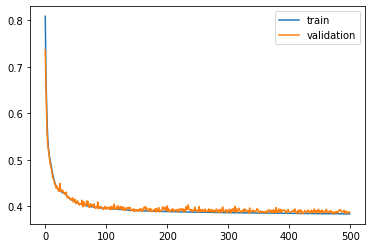

In [86]:
pd.DataFrame(trainer.loss_curve_).plot()

In [87]:
X = np.load(results_dir / "X.npy")
z, loss = trainer.predict(X)
loss

0.38374280276814476

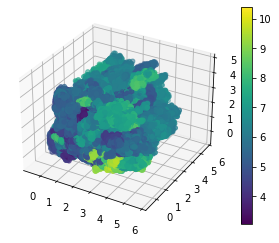

In [88]:
show_scatter(z[:, :3], e_rmsd[-1])

In [92]:
ls data


frontera/  run_final/  small_data_production-cross2/  small_positions_7egq.npy


In [94]:
labels = [] # 0
for p in data_files:
    len_data = len(np.load(p))
    if "small_positions" in str(p):
        labels.extend([0] * len_data) # post
    elif "run_final" in str(p) or "frontera" in str(p):
        labels.extend([1] * len_data) # pre
    elif "small_data_production-cross2" in str(p):
        labels.extend([2] * len_data) # ddmd

In [95]:
len(labels)

866708

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

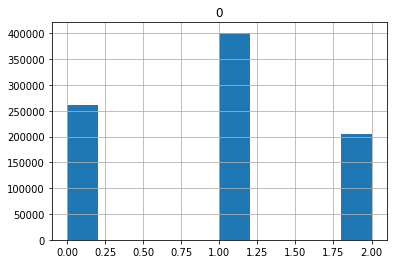

In [96]:
pd.DataFrame(labels).hist()

In [97]:
np.save(results_dir / "simulation_labels.npy", labels)

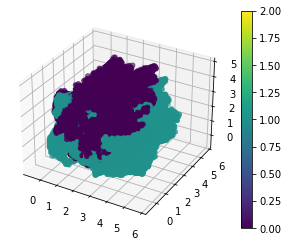

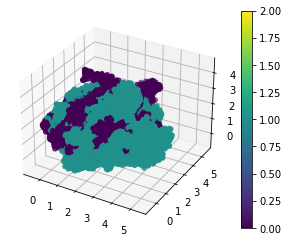

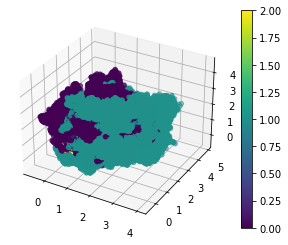

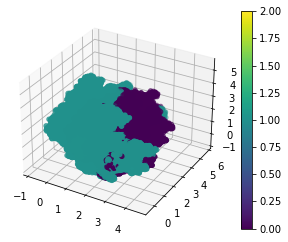

In [99]:
show_scatter(z[:, :3], labels)
show_scatter(z[:, 3:6], labels)
show_scatter(z[:, 6:9], labels)
show_scatter(z[:, 9:12], labels)


In [101]:
embeddings = {"pre": [], "post": [], "ddmd": []}
for i, label in enumerate(labels):
    if label == 0:
        embeddings["post"].append(z[i])
    elif label == 1:
        embeddings["pre"].append(z[i])
    elif label == 2:
        embeddings["ddmd"].append(z[i])
embeddings["pre"] = np.array(embeddings["pre"])
embeddings["post"] = np.array(embeddings["post"])
embeddings["ddmd"] = np.array(embeddings["ddmd"])

In [102]:
embeddings["pre"].shape

(401185, 16)

In [103]:
embeddings["post"].shape

(260723, 16)

In [104]:
embeddings["ddmd"].shape # Each frame is a picosecond for DDMD run, meaning we have 0.2048 microseconds total

(204800, 16)

In [105]:
np.save(results_dir / "pre_embeddings.npy", embeddings["pre"])
np.save(results_dir / "post_embeddings.npy", embeddings["post"])
np.save(results_dir / "ddmd_embeddings.npy", embeddings["ddmd"])